# Machine Learning & Statistics Project

## TO DO
- Finish introduction. Explain wind power and give a brief history.
- Flesh out regression model descriptions more. Check if removing the inintial 0s from the dataframe makes it more accurate
- Tidy up sources
- Create README file
- Add images
- Tidy up web interface
- Comment code

![Wind farm image](./Images/Wind_Farm.jpg)

# Introduction

We have been tasked with creating a web service that uses machine learning to make predictions based on the data set provided on power production taken from Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. We must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. Below is a breakdown of the data and a description of the modelling methods used to determine the correct algorithm for to accurately model the power production on any given wind speed.

## Wind Power Description

Wind power is a form of renewable energy that generates electrical power through the turning of a turbine in an electrical generator with the use of the force provided by the wind. Wind is an intermittent energy source providing variable power availability if not paired with another energy storage solution. The quantity of power generation from year to year is consistent but can vary wildly in the short term. There are also on shore and off shore considerations when looking at the location for these systems. While off shore winds are steadier and stronger and reduce the visual impact the construction and maintenance costs are also much greater and must be considered.

Wind power is responsible for about 5% of the global power generation. The ability to predict the output of the turbine based on the predicted wind speed would be a large advantage in future energy projections and the ability to quantify how much mitigation of energy is required in times of low winds. Generally speaking turbines follow a curve as shown below so we would expect something similar in the data we have received.

![Wind turbine curve](./Images/Wind_Turbine_Curve.png)

We will be looking to create a model to provide reliable predictions based on the empirical data provided. The data collected consists of a single csv file populated with values. Below we will explore the data.

***

# Explore the data

First we will import the required libraries and start to explore the data to get a feel for what we're dealing with taking a look at the first and last few rows and providing decriptions of the data types, shape and if there is any sections of missing data in the form of null or na valuses.

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import sklearn  
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
import tensorflow.keras as kr
from collections import Counter

#matplotlib inline
rcParams['figure.figsize']=5, 4

# Import the csv file containing the information
df = pd.read_csv('powerproduction.txt')

# Check first 10 rows to ensure we're getting correct data in as first 5 columns power outputt displayed as 0
print(f'{df.head(11)}\n')
print(f'{df.tail(15)}\n')

# Display dataframes information
print(f'{df.info()}\n')
print(f'{df.describe()}\n')
print(f'{df.shape}\n')

print(f'{df.isnull().sum()}\n')
print(f'{df.isna().sum()}')

    speed  power
0   0.000  0.000
1   0.125  0.000
2   0.150  0.000
3   0.225  0.000
4   0.275  0.000
5   0.325  4.331
6   0.400  5.186
7   0.450  3.826
8   0.501  1.048
9   0.526  5.553
10  0.551  6.498

      speed    power
485  24.249  103.700
486  24.299   93.694
487  24.349   93.078
488  24.374   98.223
489  24.399   95.117
490  24.499    0.000
491  24.525    0.000
492  24.575    0.000
493  24.650    0.000
494  24.750    0.000
495  24.775    0.000
496  24.850    0.000
497  24.875    0.000
498  24.950    0.000
499  25.000    0.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6

From the above we can see that the information received is 2 colmuns of 500 rows populated by floats. The speed range is 0-25 and the power range  is 0-113. No units are given in this table but for the purpose of this report it will be assumed the speed is measured in m/s and the power is in % of design output. 

We can see that at the minimum and maximum speed values there is a value of 0 which is showing us a minimum wind speed required to start the power generation and a high point cut off switch. We will need to visualise the data to check for anymore 0 values scattered in the data as this could potentially throw off our calculations. This indicates the data will need to be cleaned before moving forward with the prediction model generation.

The data is sorted sequentially by speed power with the power generation generally increasing with it within a certain range. This shows a relationship between the two variables. From  the graph typical turbine output grpah shown above it would appear that this is a polynomial relationship but we will need to visulaise our data before we can be sure of this.

There appears to be no missing information in the data as shown by our `df.isnull().sum()` and `df.isna().sum()` check. This data will need to be cleaned before it will be useable. Too determine if there are any other anomalies we'll plot some graphs to give a better visual representation off the data.

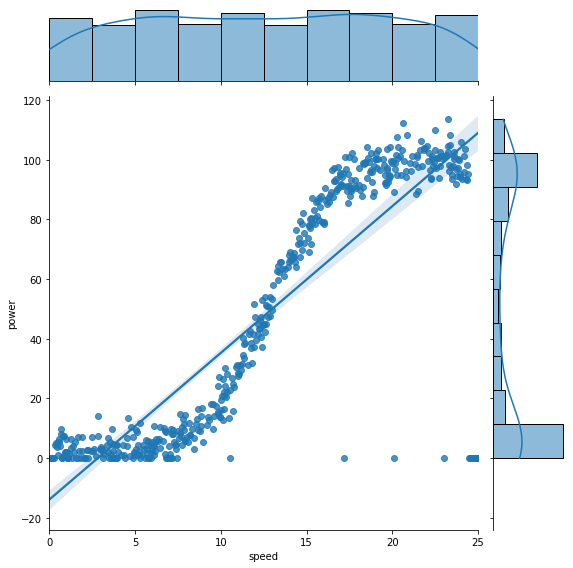

In [78]:
# Visualise dataset
sns.jointplot(data=df, x="speed", y="power",kind="reg", height=8)
#sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

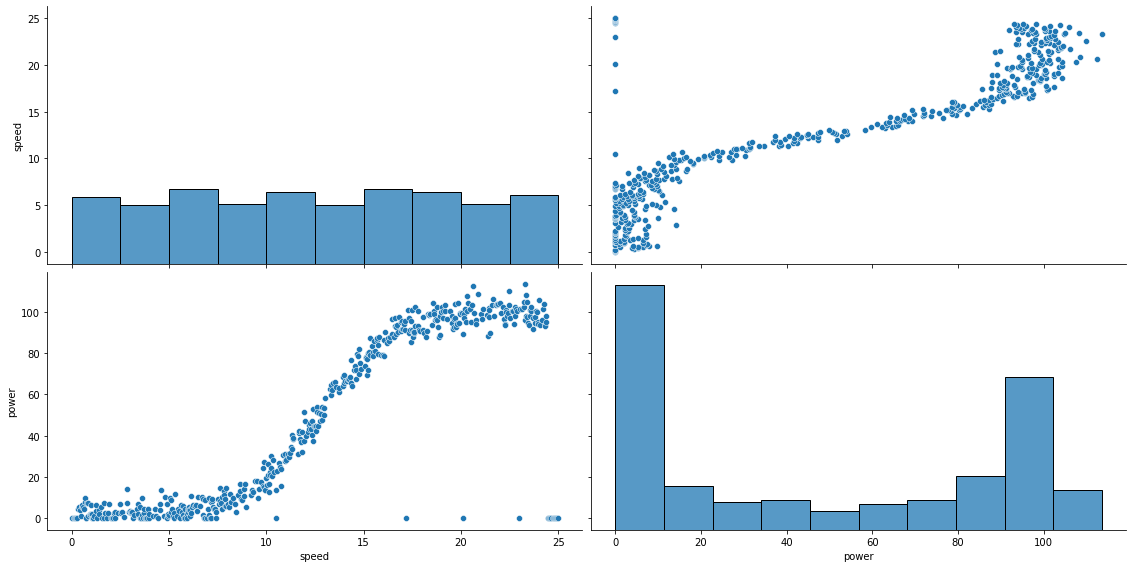

In [79]:
sns.pairplot(df, height=4, aspect=2);

The above shows us  that it is not a typical linear relationship between speed  and power and matches what we expeted with the exception of the 0 values scattered throughout. It appears the speed power relationship follows a polynomial relationship as preicted. It shows that while the wind speed is below 10 m/s the power generation remains low. From 10 to around 18 m/s there is a much faster growth of power generation before peaking out around the 100% mark at about 18  m/s wind speed where it remains until the wind speed reaches 24.5 m/s when an automatic cut off takes effect dropping power generation to 0.

In relation to the zero values scattered throughout the data this could be due to a malfunction or maintenance period on the turbine itself so these will need to be removed before moving forward to determine an accurate algorithm. The zero values at the start and end will also be removed to ensure we hve an accurate model to work with based on the power generation timees only and not have the shut down periods affecting the data.

##  Clean Data

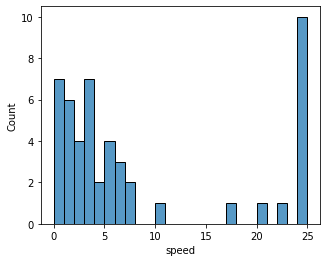

In [80]:
#  Check were majority of readings for 0 power generation values are located. 
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);


It appears the vast majority of the 0 readings are at both the low and high ends. From our inital look at the head and tail of the data we can see that the power generation doesn't start until 0.325 m/s wind speed and cuts out from 24.499 m/s wind speed. From our research we have found this to be a typical  setup for the wind turbines. 

We will now  use this information to remove all values of 0 that this is due to a malfunction or a maintenance period and therefore should not have any influence on our alogrithm generation as it is an independent event that has no bearing on the data. The high and low end cut off also needs to be removed to ensure accuracy in our prerdictions.

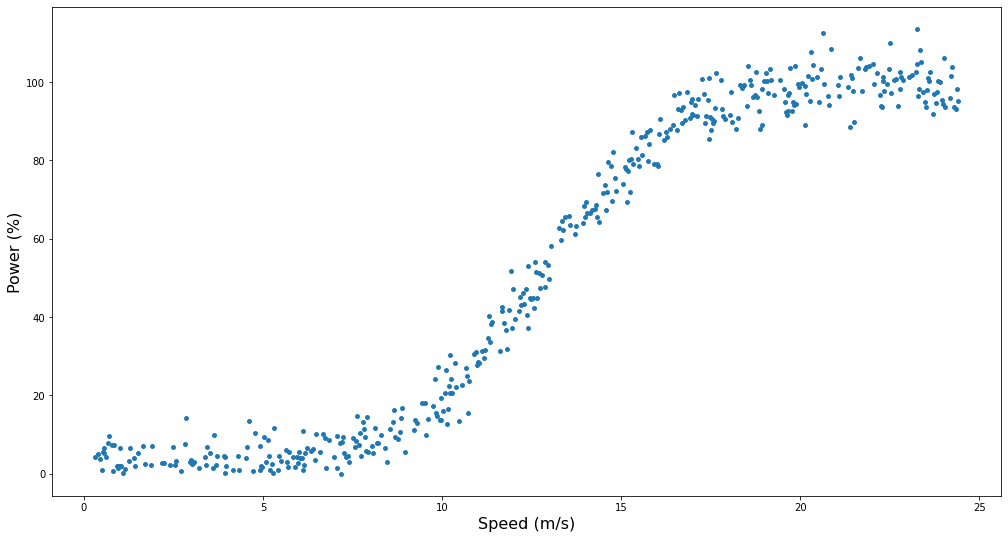

In [81]:
# https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
df = df.drop(df[df.power == 0.0].index)

# Plot scatter graph
plt.figure(figsize=(17,9))
plt.scatter(x,y,s=15)
plt.xlabel('Speed (m/s)',fontsize=16)
plt.ylabel('Power (%)',fontsize=16)
plt.show()

(451, 2)

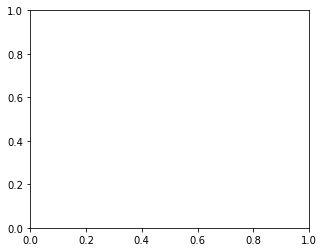

In [82]:
# Confirm all zero valuees have been removed.
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);

df.shape

Confirmation that all zero values have been removed. Now we have explored the data and we  have an idea of what it is we are looking at we'll start to model the data using various models to determine the most accurate representation to use. 

***

## Linear Regression



Linear regression is the approach of modelling the independent (also known as explanatory) and dependent variables by fitting a linear equation to some observed data. The equation for a simple linear regression model generally takes the form of- 
\begin{gather*}
y = \alpha +  \beta x_{i}\\ 
\alpha = the \hspace{2mm} intercept\\
\beta = the \hspace{2mm} slope\\
y = dependent \hspace{2mm} variable\\
x_{i} = independent \hspace{2mm} variable\\
\end{gather*}


This creates predictive values providinga straight line prediction of the curve as shown by the blue line below-

![Typical Linear Regression Curve](./Images/Lin_Reg.png)

Looking  at the graphs from our exploring the data section it does not look  like this would be a good fit. I believe this will not lead to an accurate predictor model but afterwards we can look at polynomial regression to make the fit more suitable and compare thhe different models in terms of accuracy.

In [83]:
# https://www.analyticsvidhya.com/blog/2020/03/polynomial-regression-python/v
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Generate data and convert to arrays to prepare for use
y = df.power.to_numpy() 
x = df.speed.to_numpy().reshape(-1, 1)

# Training Model
lm=LinearRegression()
lm.fit(x.reshape(-1,1),y.reshape(-1,1))

# Generate predition variable
y_pred=lm.predict(x.reshape(-1,1))

In [84]:
# Test refers to the wind power entered to provide a predicted value. Emp refers to the empirical data from csv file received
test1, emp1 = df.at[12,'speed'], df.at[12,'power']
test2, emp2 = df.at[97,'speed'] , df.at[97,'power'] 
test3, emp3 = df.at[201,'speed'], df.at[201,'power']
test4, emp4 = df.at[253,'speed'], df.at[253,'power']
test5, emp5 = df.at[293,'speed'], df.at[293,'power']
test6, emp6 = df.at[357,'speed'], df.at[357,'power']
test7, emp7 = df.at[425,'speed'], df.at[425,'power'] 

# Function ot give a positive percentage difference value
def Accuracy_L (test, emp):
    if (((lm.predict([[test]]))/emp)*100 < 100):
        return f"Undershot by {100 - ((lm.predict([[test]]))/emp)*100}%"
    else:
        return f"Overshot by {(((lm.predict([[test]]))/emp) * 100) - 100}%"

print(f'\nTest 1 (Linear)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {(lm.predict([[test1]]))}\nActual Difference: {abs(emp1-lm.predict([[test1]]))}\nAccuracy: {Accuracy_L (test1, emp1)}')
print(f'\nTest 2 (Linear)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {(lm.predict([[test2]]))}\nActual Difference: {abs(emp2-lm.predict([[test2]]))}\nAccuracy: {Accuracy_L (test2, emp2)}')
print(f'\nTest 3 (Linear)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {(lm.predict([[test3]]))}\nActual Difference: {abs(emp3-lm.predict([[test3]]))}\nAccuracy: {Accuracy_L (test3, emp3)}')
print(f'\nTest 4 (Linear)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {(lm.predict([[test4]]))}\nActual Difference: {abs(emp4-lm.predict([[test4]]))}\nAccuracy: {Accuracy_L (test4, emp4)}')
print(f'\nTest 5 (Linear)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {(lm.predict([[test5]]))}\nActual Difference: {abs(emp5-lm.predict([[test5]]))}\nAccuracy: {Accuracy_L (test5, emp5)}')
print(f'\nTest 6 (Linear)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {(lm.predict([[test6]]))}\nActual Difference: {abs(emp6-lm.predict([[test6]]))}\nAccuracy: {Accuracy_L (test6, emp6)}')
print(f'\nTest 7 (Linear)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {(lm.predict([[test7]]))}\nActual Difference: {abs(emp7-lm.predict([[test7]]))}\nAccuracy: {Accuracy_L (test7, emp7)}')



Test 1 (Linear)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[-16.32029923]]
Actual Difference: [[20.54029923]]
Accuracy: Undershot by [[486.73694848]]%

Test 2 (Linear)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[9.26784275]]
Actual Difference: [[4.74284275]]
Accuracy: Overshot by [[104.81420437]]%

Test 3 (Linear)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[37.53054677]]
Actual Difference: [[16.82654677]]
Accuracy: Overshot by [[81.27196084]]%

Test 4 (Linear)-
Wind Speed: 12.663 m/s
Empirical data: 44.88
Predicted  value: [[51.31353146]]
Actual Difference: [[6.43353146]]
Accuracy: Overshot by [[14.33496314]]%

Test 5 (Linear)-
Wind Speed: 15.065 m/s
Empirical data: 73.911
Predicted  value: [[64.80995592]]
Actual Difference: [[9.10104408]]
Accuracy: Undershot by [[12.31351771]]%

Test 6 (Linear)-
Wind Speed: 17.843 m/s
Empirical data: 91.27
Predicted  value: [[80.41905966]]
Actual Difference: [[10.85094034]]
Accuracy: Under

We can see above that while the higher value numbers are only off by about 10& the lower value numbers have a much great discrepancy between the predicted values and the actual empirically determined values. To et a better idea of why this we'll need to plot the data points with the predicted model overlaid.

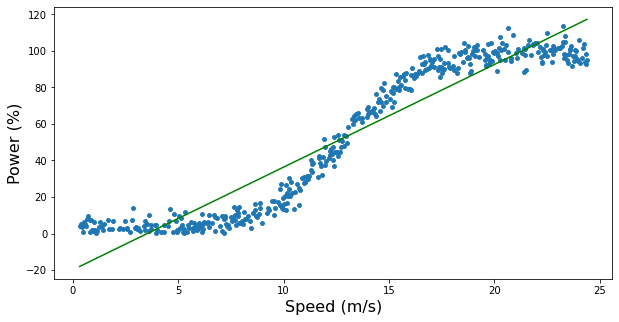

Root mean squared error for Linear Regression is 12.896688707698415
The R2 value is 0.8984832870534454


In [85]:
# Plotting predictions
plt.figure(figsize=(10,5))
plt.scatter(x,y,s=15)
plt.plot(x,y_pred,color='g')
plt.xlabel('Speed (m/s)',fontsize=16)
plt.ylabel('Power (%)',fontsize=16)
plt.show()
print(f'Root mean squared error for Linear Regression is {np.sqrt(mean_squared_error(y,y_pred))}')
print(f'The R2 value is {r2_score(y, y_pred)}')

From the above figures and corresponding graph we can see that there are large sections of the graph missed by a linear regression model. We can see very large differences particularly on the low end of the graph which explains the value we were getting for the low end test values. 

While the linear regression model type in thhe above fomrat would not be useable it does appear that the graph does have 3 distinct zones. If we split the graph into 3 sections and applied the model to each section we would greatly increase the accuracy though in that case it may be  better to apply the polynomial regression model with greater degrees of accuracy as we go through below.

***

# Polynomial Regression

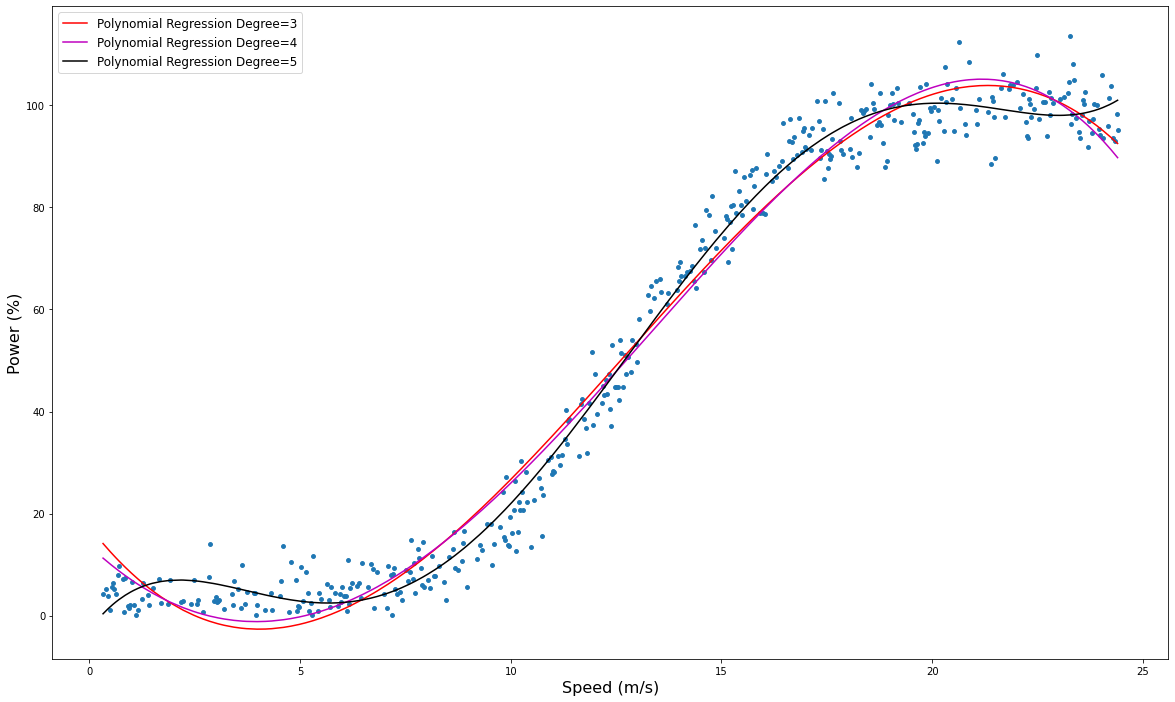

Root mean squared error for Polynomial Regression is 5.959671638433298
The R2 value is 0.9783216723216328


In [120]:
from sklearn.pipeline import Pipeline

# creating pipeline and fitting it on data
Input=[('polynomial',PolynomialFeatures(degree=3)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(x.reshape(-1,1),y.reshape(-1,1))

poly_pred=pipe.predict(x.reshape(-1,1))
#sorting predicted values with respect to predictor
sorted_zip = sorted(zip(x,poly_pred))
x_poly, poly_pred = zip(*sorted_zip)

# creating pipeline and fitting it on data
Input2=[('polynomial',PolynomialFeatures(degree=4)),('modal',LinearRegression())]
pipe2=Pipeline(Input2)
pipe2.fit(x.reshape(-1,1),y.reshape(-1,1))

poly_pred2=pipe2.predict(x.reshape(-1,1))
#sorting predicted values with respect to predictor
sorted_zip2 = sorted(zip(x,poly_pred2))
x_poly, poly_pred2 = zip(*sorted_zip2)

# creating pipeline and fitting it on data
Input3=[('polynomial',PolynomialFeatures(degree=5)),('modal',LinearRegression())]
pipe3=Pipeline(Input3)
pipe3.fit(x.reshape(-1,1),y.reshape(-1,1))

poly_pred3=pipe3.predict(x.reshape(-1,1))
#sorting predicted values with respect to predictor
sorted_zip3 = sorted(zip(x,poly_pred3))
x_poly, poly_pred3 = zip(*sorted_zip3)

#plotting predictions
plt.figure(figsize=(20,12))
plt.scatter(x,y,s=15)
plt.plot(x_poly,poly_pred,color='r',label='Polynomial Regression Degree=3')
plt.plot(x_poly,poly_pred2,color='m',label='Polynomial Regression Degree=4')
plt.plot(x_poly,poly_pred3,color='k',label='Polynomial Regression Degree=5')
plt.xlabel('Speed (m/s)',fontsize=16)
plt.ylabel('Power (%)',fontsize=16)
plt.legend(fontsize=12)
plt.show()

print(f'Root mean squared error for Polynomial Regression is {np.sqrt(mean_squared_error(y,poly_pred))}')
print(f'The R2 value is {r2_score(y, poly_pred)}')

In [87]:
# Function ot give a positive percentage difference value
def Accuracy_P (test, emp):
    if ((pipe.predict([[test]])/emp)*100 < 100):
        return f"Undershot by {100 - (pipe.predict([[test]])/emp)*100}%"
    else:
        return f"Overshot by {((pipe.predict([[test]])/emp) * 100) - 100}%"

print(f'\nTest 1 (Polynomial)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {pipe.predict([[test1]])}\nActual Difference: {abs(emp1-pipe.predict([[test1]]))}\nAccuracy: {Accuracy_P (test1, emp1)}')
print(f'\nTest 2 (Polynomial)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {pipe.predict([[test2]])}\nActual Difference: {abs(emp2-pipe.predict([[test2]]))}\nAccuracy: {Accuracy_P (test2, emp2)}')
print(f'\nTest 3 (Polynomial)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {pipe.predict([[test3]])}\nActual Difference: {abs(emp3-pipe.predict([[test3]]))}\nAccuracy: {Accuracy_P (test3, emp3)}')
print(f'\nTest 4 (Polynomial)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {pipe.predict([[test4]])}\nActual Difference: {abs(emp4-pipe.predict([[test4]]))}\nAccuracy: {Accuracy_P (test4, emp4)}')
print(f'\nTest 5 (Polynomial)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {pipe.predict([[test5]])}\nActual Difference: {abs(emp5-pipe.predict([[test5]]))}\nAccuracy: {Accuracy_P (test5, emp5)}')
print(f'\nTest 6 (Polynomial)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {pipe.predict([[test6]])}\nActual Difference: {abs(emp6-pipe.predict([[test6]]))}\nAccuracy: {Accuracy_P (test6, emp6)}')
print(f'\nTest 7 (Polynomial)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {pipe.predict([[test7]])}\nActual Difference: {abs(emp7-pipe.predict([[test7]]))}\nAccuracy: {Accuracy_P (test7, emp7)}')


Test 1 (Polynomial)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[2.67711841]]
Actual Difference: [[1.54288159]]
Accuracy: Undershot by [[36.56117507]]%

Test 2 (Polynomial)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[2.68721213]]
Actual Difference: [[1.83778787]]
Accuracy: Undershot by [[40.61409653]]%

Test 3 (Polynomial)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[23.86608597]]
Actual Difference: [[3.16208597]]
Accuracy: Overshot by [[15.27282635]]%

Test 4 (Polynomial)-
Wind Speed: 12.663 m/s
Empirical data: 44.88
Predicted  value: [[49.66033424]]
Actual Difference: [[4.78033424]]
Accuracy: Overshot by [[10.65136862]]%

Test 5 (Polynomial)-
Wind Speed: 15.065 m/s
Empirical data: 73.911
Predicted  value: [[75.45779068]]
Actual Difference: [[1.54679068]]
Accuracy: Overshot by [[2.09277466]]%

Test 6 (Polynomial)-
Wind Speed: 17.843 m/s
Empirical data: 91.27
Predicted  value: [[95.61249786]]
Actual Difference: [[4.34249786]]

***

## Neural Networks

In [98]:
poly = df
test = df

# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(20, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

model.compile('adam', loss='mean_squared_error') #Test

# Fit the data.
model.fit(poly['speed'], poly['power'], epochs=500, batch_size=10)

Epoch 1/500
46/46 [==============================] - 0s 778us/step - loss: 3895.6896
Epoch 2/500
46/46 [==============================] - 0s 890us/step - loss: 4427.7309
Epoch 3/500
46/46 [==============================] - 0s 820us/step - loss: 4362.9274
Epoch 4/500
46/46 [==============================] - 0s 775us/step - loss: 4150.6497
Epoch 5/500
46/46 [==============================] - 0s 800us/step - loss: 4132.0102
Epoch 6/500
46/46 [==============================] - 0s 902us/step - loss: 3670.2783
Epoch 7/500
46/46 [==============================] - 0s 864us/step - loss: 3837.6638
Epoch 8/500
46/46 [==============================] - 0s 861us/step - loss: 3598.6581
Epoch 9/500
46/46 [==============================] - 0s 1ms/step - loss: 3554.1010
Epoch 10/500
46/46 [==============================] - 0s 952us/step - loss: 3412.2720
Epoch 11/500
46/46 [==============================] - 0s 954us/step - loss: 3423.8578
Epoch 12/500
46/46 [==============================] - 0s 925us/st

46/46 [==============================] - 0s 863us/step - loss: 798.7575
Epoch 98/500
46/46 [==============================] - 0s 841us/step - loss: 777.9977
Epoch 99/500
46/46 [==============================] - 0s 822us/step - loss: 792.6212
Epoch 100/500
46/46 [==============================] - 0s 791us/step - loss: 800.4368
Epoch 101/500
46/46 [==============================] - 0s 802us/step - loss: 776.4878
Epoch 102/500
46/46 [==============================] - 0s 815us/step - loss: 762.2214
Epoch 103/500
46/46 [==============================] - 0s 838us/step - loss: 722.6218
Epoch 104/500
46/46 [==============================] - 0s 854us/step - loss: 736.1750
Epoch 105/500
46/46 [==============================] - 0s 819us/step - loss: 663.7195
Epoch 106/500
46/46 [==============================] - 0s 953us/step - loss: 661.0752
Epoch 107/500
46/46 [==============================] - 0s 831us/step - loss: 695.3414
Epoch 108/500
46/46 [==============================] - 0s 798us/step -

46/46 [==============================] - 0s 1ms/step - loss: 75.6163
Epoch 195/500
46/46 [==============================] - 0s 1ms/step - loss: 76.0947
Epoch 196/500
46/46 [==============================] - 0s 1ms/step - loss: 78.0505
Epoch 197/500
46/46 [==============================] - 0s 1ms/step - loss: 81.1226
Epoch 198/500
46/46 [==============================] - 0s 2ms/step - loss: 67.7675
Epoch 199/500
46/46 [==============================] - 0s 1ms/step - loss: 69.9447
Epoch 200/500
46/46 [==============================] - 0s 2ms/step - loss: 69.4531
Epoch 201/500
46/46 [==============================] - 0s 2ms/step - loss: 64.5184
Epoch 202/500
46/46 [==============================] - 0s 1ms/step - loss: 66.1559
Epoch 203/500
46/46 [==============================] - 0s 2ms/step - loss: 66.2988
Epoch 204/500
46/46 [==============================] - 0s 1ms/step - loss: 65.8219
Epoch 205/500
46/46 [==============================] - 0s 1ms/step - loss: 63.1237
Epoch 206/500
46/4

46/46 [==============================] - 0s 1ms/step - loss: 24.6949
Epoch 293/500
46/46 [==============================] - 0s 1ms/step - loss: 24.4918
Epoch 294/500
46/46 [==============================] - 0s 1ms/step - loss: 23.8570
Epoch 295/500
46/46 [==============================] - 0s 1ms/step - loss: 23.4751
Epoch 296/500
46/46 [==============================] - 0s 1ms/step - loss: 24.9374
Epoch 297/500
46/46 [==============================] - 0s 1ms/step - loss: 24.6448
Epoch 298/500
46/46 [==============================] - 0s 2ms/step - loss: 23.3340
Epoch 299/500
46/46 [==============================] - 0s 1ms/step - loss: 22.2804
Epoch 300/500
46/46 [==============================] - 0s 2ms/step - loss: 25.9503
Epoch 301/500
46/46 [==============================] - 0s 2ms/step - loss: 24.4209
Epoch 302/500
46/46 [==============================] - 0s 1ms/step - loss: 24.2642
Epoch 303/500
46/46 [==============================] - 0s 2ms/step - loss: 20.1999
Epoch 304/500
46/4

46/46 [==============================] - 0s 674us/step - loss: 18.2277
Epoch 391/500
46/46 [==============================] - 0s 773us/step - loss: 18.3064
Epoch 392/500
46/46 [==============================] - 0s 743us/step - loss: 19.1661
Epoch 393/500
46/46 [==============================] - 0s 723us/step - loss: 19.4632
Epoch 394/500
46/46 [==============================] - 0s 738us/step - loss: 16.5426
Epoch 395/500
46/46 [==============================] - 0s 821us/step - loss: 16.5013
Epoch 396/500
46/46 [==============================] - 0s 746us/step - loss: 19.4395
Epoch 397/500
46/46 [==============================] - 0s 772us/step - loss: 17.8451
Epoch 398/500
46/46 [==============================] - 0s 708us/step - loss: 20.4551
Epoch 399/500
46/46 [==============================] - 0s 698us/step - loss: 17.2141
Epoch 400/500
46/46 [==============================] - 0s 744us/step - loss: 17.5033
Epoch 401/500
46/46 [==============================] - 0s 733us/step - loss: 18

46/46 [==============================] - 0s 693us/step - loss: 16.8302
Epoch 487/500
46/46 [==============================] - 0s 778us/step - loss: 17.6697
Epoch 488/500
46/46 [==============================] - 0s 685us/step - loss: 15.7314
Epoch 489/500
46/46 [==============================] - 0s 667us/step - loss: 18.7030
Epoch 490/500
46/46 [==============================] - 0s 643us/step - loss: 15.6711
Epoch 491/500
46/46 [==============================] - 0s 668us/step - loss: 16.6157
Epoch 492/500
46/46 [==============================] - 0s 711us/step - loss: 17.5762
Epoch 493/500
46/46 [==============================] - 0s 659us/step - loss: 15.2902
Epoch 494/500
46/46 [==============================] - 0s 656us/step - loss: 17.2437
Epoch 495/500
46/46 [==============================] - 0s 665us/step - loss: 16.7988
Epoch 496/500
46/46 [==============================] - 0s 671us/step - loss: 16.2285
Epoch 497/500
46/46 [==============================] - 0s 682us/step - loss: 16

In [89]:
# Function ot give a positive percentage difference value
def Accuracy_N (test, emp):
    if ((model.predict([test])/emp)*100 < 100):
        return f"Undershot by {(100 - ((model.predict([test]))/emp)*100)}%"
    else:
        return f"Overshot by {(((model.predict([test]))/emp) * 100) - 100}%"
    
print(f'\nTest 1 (Neural Network)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {model.predict([test1])}\nActual Difference: {abs(emp1-model.predict([test1]))}\nAccuracy: {Accuracy_N (test1, emp1)}')
print(f'\nTest 2 (Neural Network)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {model.predict([test2])}\nActual Difference: {abs(emp2-model.predict([test2]))}\nAccuracy: {Accuracy_N (test2, emp2)}')
print(f'\nTest 3 (Neural Network)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {model.predict([test3])}\nActual Difference: {abs(emp3-model.predict([test3]))}\nAccuracy: {Accuracy_N (test3, emp3)}')
print(f'\nTest 4 (Neural Network)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {model.predict([test4])}\nActual Difference: {abs(emp4-model.predict([test4]))}\nAccuracy: {Accuracy_N (test4, emp4)}')
print(f'\nTest 5 (Neural Network)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {model.predict([test5])}\nActual Difference: {abs(emp5-model.predict([test5]))}\nAccuracy: {Accuracy_N (test5, emp5)}')
print(f'\nTest 6 (Neural Network)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {model.predict([test6])}\nActual Difference: {abs(emp6-model.predict([test6]))}\nAccuracy: {Accuracy_N (test6, emp6)}')
print(f'\nTest 7 (Neural Network)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {model.predict([test7])}\nActual Difference: {abs(emp7-model.predict([test7]))}\nAccuracy: {Accuracy_N (test7, emp7)}')


Test 1 (Neural Network)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[4.114172]]
Actual Difference: [[0.10582781]]
Accuracy: Undershot by [[2.5077667]]%

Test 2 (Neural Network)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[4.348634]]
Actual Difference: [[0.17636633]]
Accuracy: Undershot by [[3.8975983]]%

Test 3 (Neural Network)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[21.467823]]
Actual Difference: [[0.76382256]]
Accuracy: Overshot by [[3.6892548]]%

Test 4 (Neural Network)-
Wind Speed: 12.663 m/s
Empirical data: 44.88
Predicted  value: [[49.74388]]
Actual Difference: [[4.86388]]
Accuracy: Overshot by [[10.837517]]%

Test 5 (Neural Network)-
Wind Speed: 15.065 m/s
Empirical data: 73.911
Predicted  value: [[77.48159]]
Actual Difference: [[3.5705872]]
Accuracy: Overshot by [[4.8309326]]%

Test 6 (Neural Network)-
Wind Speed: 17.843 m/s
Empirical data: 91.27
Predicted  value: [[93.981224]]
Actual Difference: [[2.7112274]]
Acc

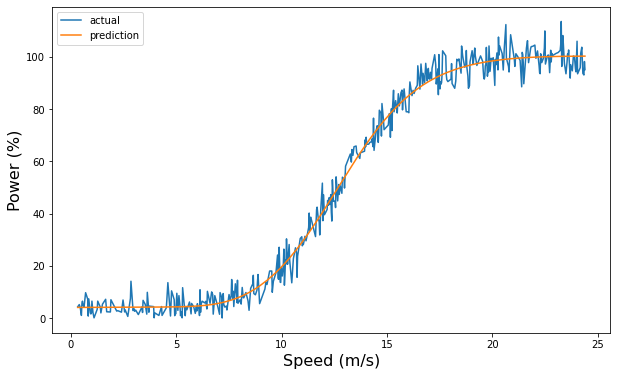

In [90]:
# Graph prediction
plt.figure(figsize=(10,6))
plt.plot(poly['speed'], poly['power'], label='actual')
plt.plot(poly['speed'], model.predict(poly['speed']), label='prediction')
plt.xlabel('Speed (m/s)',fontsize=16)
plt.ylabel('Power (%)',fontsize=16)
plt.legend()
plt.show()

Mean squared error same as root mean squared error just without using the square root part. 

### Models Compared

Test 1 (Linear)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[-16.32029923]]
Actual Difference: [[20.54029923]]
Accuracy: Undershot by [[486.73694848]]%

Test 1 (Polynomial)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[2.67711841]]
Actual Difference: [[1.54288159]]
Accuracy: Undershot by [[36.56117507]]%

Test 1 (Neural Network)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[4.114172]]
Actual Difference: [[0.10582781]]
Accuracy: Undershot by [[2.5077667]]%

Test 2 (Linear)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[9.26784275]]
Actual Difference: [[4.74284275]]
Accuracy: Overshot by [[104.81420437]]%

Test 2 (Polynomial)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[2.68721213]]
Actual Difference: [[1.83778787]]
Accuracy: Undershot by [[40.61409653]]%

Test 2 (Neural Network)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[4.348634]]
Actual Difference: [[0.17636633]]
Accuracy: U

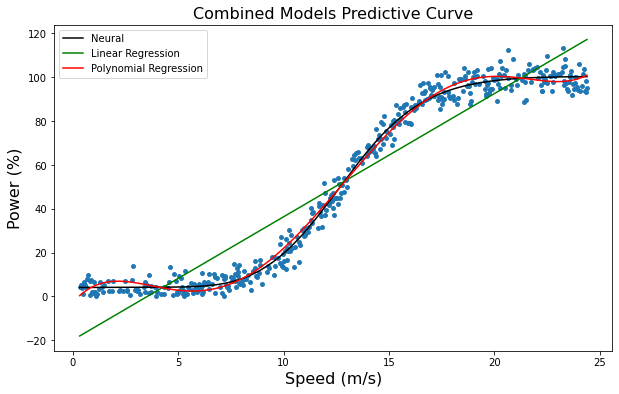

In [95]:
print(f'Test 1 (Linear)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {(lm.predict([[test1]]))}\nActual Difference: {abs(emp1-lm.predict([[test1]]))}\nAccuracy: {AccuracyL (test1, emp1)}')
print(f'\nTest 1 (Polynomial)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {pipe.predict([[test1]])}\nActual Difference: {abs(emp1-pipe.predict([[test1]]))}\nAccuracy: {AccuracyP (test1, emp1)}')
print(f'\nTest 1 (Neural Network)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {model.predict([test1])}\nActual Difference: {abs(emp1-model.predict([test1]))}\nAccuracy: {Accuracy_N (test1, emp1)}')
print(f'\nTest 2 (Linear)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {(lm.predict([[test2]]))}\nActual Difference: {abs(emp2-lm.predict([[test2]]))}\nAccuracy: {AccuracyL (test2, emp2)}')
print(f'\nTest 2 (Polynomial)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {pipe.predict([[test2]])}\nActual Difference: {abs(emp2-pipe.predict([[test2]]))}\nAccuracy: {AccuracyP (test2, emp2)}')
print(f'\nTest 2 (Neural Network)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {model.predict([test2])}\nActual Difference: {abs(emp2-model.predict([test2]))}\nAccuracy: {Accuracy_N (test2, emp2)}')
print(f'\nTest 3 (Linear)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {(lm.predict([[test3]]))}\nActual Difference: {abs(emp3-lm.predict([[test3]]))}\nAccuracy: {AccuracyL (test3, emp3)}')
print(f'\nTest 3 (Polynomial)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {pipe.predict([[test3]])}\nActual Difference: {abs(emp3-pipe.predict([[test3]]))}\nAccuracy: {AccuracyP (test3, emp3)}')
print(f'\nTest 3 (Neural Network)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {model.predict([test3])}\nActual Difference: {abs(emp3-model.predict([test3]))}\nAccuracy: {Accuracy_N (test3, emp3)}')
print(f'\nTest 4 (Linear)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {(lm.predict([[test4]]))}\nActual Difference: {abs(emp4-lm.predict([[test4]]))}\nAccuracy: {AccuracyL (test4, emp4)}')
print(f'\nTest 4 (Polynomial)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {pipe.predict([[test4]])}\nActual Difference: {abs(emp4-pipe.predict([[test4]]))}\nAccuracy: {AccuracyP (test4, emp4)}')
print(f'\nTest 4 (Neural Network)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {model.predict([test4])}\nActual Difference: {abs(emp4-model.predict([test4]))}\nAccuracy: {Accuracy_N (test4, emp4)}')
print(f'\nTest 5 (Linear)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {(lm.predict([[test5]]))}\nActual Difference: {abs(emp5-lm.predict([[test5]]))}\nAccuracy: {AccuracyL (test5, emp5)}')
print(f'\nTest 5 (Polynomial)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {pipe.predict([[test5]])}\nActual Difference: {abs(emp5-pipe.predict([[test5]]))}\nAccuracy: {AccuracyP (test5, emp5)}')
print(f'\nTest 5 (Neural Network)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {model.predict([test5])}\nActual Difference: {abs(emp5-model.predict([test5]))}\nAccuracy: {Accuracy_N (test5, emp5)}')
print(f'\nTest 6 (Linear)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {(lm.predict([[test6]]))}\nActual Difference: {abs(emp6-lm.predict([[test6]]))}\nAccuracy: {AccuracyL (test6, emp6)}')
print(f'\nTest 6 (Polynomial)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {pipe.predict([[test6]])}\nActual Difference: {abs(emp6-pipe.predict([[test6]]))}\nAccuracy: {AccuracyP (test6, emp6)}')
print(f'\nTest 6 (Neural Network)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {model.predict([test6])}\nActual Difference: {abs(emp6-model.predict([test6]))}\nAccuracy: {Accuracy_N (test6, emp6)}')
print(f'\nTest 7 (Linear)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {(lm.predict([[test7]]))}\nActual Difference: {abs(emp7-lm.predict([[test7]]))}\nAccuracy: {AccuracyL (test7, emp7)}')
print(f'\nTest 7 (Polynomial)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {pipe.predict([[test7]])}\nActual Difference: {abs(emp7-pipe.predict([[test7]]))}\nAccuracy: {AccuracyP (test7, emp7)}')
print(f'\nTest 7 (Neural Network)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {model.predict([test7])}\nActual Difference: {abs(emp7-model.predict([test7]))}\nAccuracy: {Accuracy_N (test7, emp7)}')

#plotting predictions
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=15)
plt.plot(poly['speed'], model.predict(poly['speed']), color='k', label='Neural')
plt.plot(x,y_pred,color='g',label='Linear Regression')
plt.plot(x_poly,poly_pred,color='r',label='Polynomial Regression')
plt.title('Combined Models Predictive Curve',fontsize=16)
plt.xlabel('Speed (m/s)',fontsize=16)
plt.ylabel('Power (%)',fontsize=16)
plt.legend()
plt.show()

### Save Neural Networks Model To JSON

In [92]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Load Neural Networks Model From JSON File

In [93]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [94]:
# evaluate loaded model on test data
#loaded_model.compile('adam', loss='mean_squared_error')

print(f'\nTest 1 (Neural Network)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {loaded_model.predict([test1])}\nActual Difference: {abs(emp1-loaded_model.predict([test1]))}\nAccuracy: {AccuracyN (test1, emp1)}')
print(f'\nTest 2 (Neural Network)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {loaded_model.predict([test2])}\nActual Difference: {abs(emp2-loaded_model.predict([test2]))}\nAccuracy: {AccuracyN (test2, emp2)}')
print(f'\nTest 3 (Neural Network)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {loaded_model.predict([test3])}\nActual Difference: {abs(emp3-loaded_model.predict([test3]))}\nAccuracy: {AccuracyN (test3, emp3)}')
print(f'\nTest 4 (Neural Network)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {loaded_model.predict([test4])}\nActual Difference: {abs(emp4-loaded_model.predict([test4]))}\nAccuracy: {AccuracyN (test4, emp4)}')
print(f'\nTest 5 (Neural Network)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {loaded_model.predict([test5])}\nActual Difference: {abs(emp5-loaded_model.predict([test5]))}\nAccuracy: {AccuracyN (test5, emp5)}')
print(f'\nTest 6 (Neural Network)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {loaded_model.predict([test6])}\nActual Difference: {abs(emp6-loaded_model.predict([test6]))}\nAccuracy: {AccuracyN (test6, emp6)}')
print(f'\nTest 7 (Neural Network)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {loaded_model.predict([test7])}\nActual Difference: {abs(emp7-loaded_model.predict([test7]))}\nAccuracy: {AccuracyN (test7, emp7)}')


Test 1 (Neural Network)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[4.114172]]
Actual Difference: [[0.10582781]]
Accuracy: Undershot by [[2.5077667]]%

Test 2 (Neural Network)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[4.348634]]
Actual Difference: [[0.17636633]]
Accuracy: Undershot by [[3.8975983]]%

Test 3 (Neural Network)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[21.467823]]
Actual Difference: [[0.76382256]]
Accuracy: Overshot by [[3.6892548]]%

Test 4 (Neural Network)-
Wind Speed: 12.663 m/s
Empirical data: 44.88
Predicted  value: [[49.74388]]
Actual Difference: [[4.86388]]
Accuracy: Overshot by [[10.837517]]%

Test 5 (Neural Network)-
Wind Speed: 15.065 m/s
Empirical data: 73.911
Predicted  value: [[77.48159]]
Actual Difference: [[3.5705872]]
Accuracy: Overshot by [[4.8309326]]%

Test 6 (Neural Network)-
Wind Speed: 17.843 m/s
Empirical data: 91.27
Predicted  value: [[93.981224]]
Actual Difference: [[2.7112274]]
Acc

## Sources

https://en.wikipedia.org/wiki/Wind_power (wind description)

https://www.sciencedirect.com/science/article/pii/S0960148119306196 (More wind description breakdowns)

https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=In%20order%20to%20check%20missing,null%20values%20in%20a%20series.

https://realpython.com/linear-regression-in-python/

https://towardsdatascience.com/polynomial-regression-from-scratch-in-python-1f34a3a5f373(poly regr)

https://statisticsbyjim.com/regression/curve-fitting-linear-nonlinear-regress(poly regr)

https://statisticsbyjim.com/regression/interpret-r-squared-regression/ (R2)

https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 (poly lin regr)

https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/

https://datascienceplus.com/keras-regression-based-neural-networks/ (keras)

https://machinelearningmastery.com/save-load-keras-deep-learning-models/ (saving keras result)

https://towardsdatascience.com/deploying-a-keras-deep-learning-model-as-a-web-application-in-p-fc0f2354a7ff (Deploying as web app)

https://www.vernier.com/til/1014 (RMSE MSE)

https://en.wikipedia.org/wiki/Linear_regression Linear regression description

http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm More linear regression descriptions

https://wch.github.io/latexsheet/ Llatex